In [1]:
import get_data as gd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import Asset as a
import numpy as np
import random
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [2]:
# set some hyperparameters
NUMBER_OF_GENERATION = 3
POPULATION_SIZE = 2000
MUTATION_PROBABILITY = 0.3
HIGHEST_WINDOWSIZE = 30
LOWEST_WINDOWSIZE = 4
HIGHEST_HIGHTHRESHOLD = 90
LOWEST_HIGHRESHOLD = 60
HIGHEST_LOWTHRESHOLD = 50
LOWEST_LOWTHRESHOLD = 15
MUTATION_HIGH = 1.5
MUTATION_LOW = 0.67

In [3]:
def create_population(size):
    population = []
    # generate population by random parameters(genes)
    for _ in range(size):
        windowsize = random.randint(LOWEST_WINDOWSIZE, HIGHEST_WINDOWSIZE)
        highthreshold = random.uniform(LOWEST_HIGHRESHOLD, HIGHEST_HIGHTHRESHOLD)
        lowthreshold = random.uniform(LOWEST_LOWTHRESHOLD, HIGHEST_LOWTHRESHOLD)
        individual = (windowsize, highthreshold, lowthreshold)
        population.append(individual)
    return population

In [4]:
def apply_strategy(data, individual, start_time, end_time):
    # initialize some variables
    windowsize, highthreshold, lowthreshold = individual
    rsi = RSIIndicator(data["close"], window=windowsize)
    data["rsi"] = rsi.rsi()
    btc = np.asarray(data["close"])
    asset = a.Asset()
    in_position = False
    money_progress = []
    
    # apply buy and sell strategy
    for i in range(start_time, end_time + 1):
        # buy
        if not in_position and data["rsi"].iloc[i] < lowthreshold:
            asset.buy(btc[i + 1])
            in_position = True
        # sell
        elif in_position and data["rsi"].iloc[i] > highthreshold:
            asset.sell(btc[i + 1])
            in_position = False
        # store the value of money in each iteration
        money_progress.append(asset.money + asset.coin * btc[i + 1])

    if in_position:
        asset.sell(btc[-1])

    money_progress.append(asset.money)

    return money_progress

# calculate fitness of each individual
# def calculate_fitness(data, individual, start_time, end_time):
#     money_progress = apply_strategy(data, individual, start_time, end_time)
#     fitness = money_progress[-1] - 100
#     # if fitness is negative, set it to 0
#     return max(fitness, 0)
def calculate_fitness(data, individual, start_time, end_time):
    money_progress = apply_strategy(data, individual, start_time, end_time)
    score = money_progress[-1]
    return score

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# calculate the probability of each individual and select them as the parents of next generation
def roulette_wheel_selection(population, fitness):
    softmax_fitness = softmax(fitness)
    selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=softmax_fitness)
    return [population[i] for i in selected_indices]

# def roulette_wheel_selection(population, fitness):
#     total_fitness = sum(fitness)
#     if total_fitness == 0:
#         raise ValueError("The total fitness is 0, please try to run the program again.")
#     probabilities = [f / total_fitness for f in fitness]
#     selected_indices = np.random.choice(range(len(population)), size=2, replace=False, p=probabilities)
#     return [population[i] for i in selected_indices]

In [5]:
# crossover the parents to generate children
def crossover(parents):
    child1, child2 = parents
    crossover_point = random.randint(1, 2)
    child1 = child1[:crossover_point] + child2[crossover_point:]
    child2 = child2[:crossover_point] + child1[crossover_point:]
    return child1, child2

In [6]:
# mutate the children
def mutation(child):
    # set some variables about mutation
    mutation_prob = MUTATION_PROBABILITY
    mutated_gene_index = random.randint(0, 2)
    mutation_factor = random.uniform(MUTATION_LOW, MUTATION_HIGH)
    
    child = list(child)
    # if the random number is smaller than mutation probability, mutate the child
    if random.random() < mutation_prob:
        # mutate the gene by multiplying the mutation factor
        child[mutated_gene_index] *= mutation_factor
        # restrict the value of the gene
        if mutated_gene_index == 0:
            child[mutated_gene_index] = max(min(HIGHEST_WINDOWSIZE, int(child[mutated_gene_index])), LOWEST_WINDOWSIZE)
        elif mutated_gene_index == 1:
            child[mutated_gene_index] = max(min(HIGHEST_HIGHTHRESHOLD, child[mutated_gene_index]), LOWEST_HIGHRESHOLD)
        else:
            child[mutated_gene_index] = max(min(HIGHEST_LOWTHRESHOLD, child[mutated_gene_index]), LOWEST_LOWTHRESHOLD)

    return tuple(child)

In [7]:
def draw_top_individuals(top_individuals, start_time, end_time):
    # plot the money progress of the top 4 individuals in last generation
    color_list = ['r', 'b', 'g', 'k']
    plt.figure(figsize=(8, 4))
    for idx, (individual, fit) in enumerate(top_individuals[:4]):
        days = range(start_time, end_time + 2)
        money_progress = apply_strategy(df_data, individual, start_time, end_time)
        plt.plot(days, money_progress, color=color_list[idx], label=f"Individual {idx + 1}: {individual}")
    plt.legend(loc='upper left')
    plt.title("Top 4 Individuals - Money Progress")
    plt.xlabel("Day")
    plt.ylabel("Money(AUD)")
    # plt.savefig("figure/Top4IndividualsMoneyProgress.png")
    plt.show()

In [8]:
def genetic_algorithm(data, start_time, end_time):
    # initialize the population
    population = create_population(POPULATION_SIZE)

    # run the algorithm for several generations
    for generation in range(NUMBER_OF_GENERATION):
        # calculate the fitness of each individual
        fitness = [calculate_fitness(data, individual, start_time, end_time) for individual in population]
        new_population = []

        # print the top 10 individuals and their fitness
        print(f"Generation {generation + 1}: Top 10 individuals and their fitness:")
        top_individuals = sorted(zip(population, fitness), key=lambda x: x[1], reverse=True)[:10]
        for individual, fit in top_individuals:
            print(f"Individual {individual} - Fitness: {fit:.2f}")
            
        draw_top_individuals(top_individuals, start_time, end_time)

        # generate new population by crossover and mutation
        while len(new_population) < POPULATION_SIZE:
            parents = roulette_wheel_selection(population, fitness)
            child1, child2 = crossover(parents)
            child1 = mutation(child1)
            child2 = mutation(child2)
            new_population.extend([child1, child2])

        population = new_population
    
    # return the top 10 individuals
    return top_individuals

In [9]:
df_data = gd.grab_data()

The day from  400  to  499 days.
------------------------train---------------------------
Generation 1: Top 10 individuals and their fitness:
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (4, 73.20417104564925, 40.55430876495531) - Fitness: 152.83
Individual (7, 64.6460845235085, 38.48336006259156) - Fitness: 152.77
Individual (7, 63.48977040290808, 37.791783224228695) - Fitness: 152.77
Individual (8, 63.609502832008786, 44.448900674541505) - Fitness: 151.87
Individual (4, 76.61504475683941, 37.25005674658012) - Fitness: 151.64
Individual (4, 74.18553836919568, 39.29155229897227) - Fitness: 151.64
Individual (4, 76.25019773135332, 37.259246126457555) - Fitness: 151.64
Individual (4, 77.54974884402536, 38.36955991419079) - Fitness: 151.64
Individual (4, 75.76804020163831, 34.92096772031147) - Fitness: 151.64


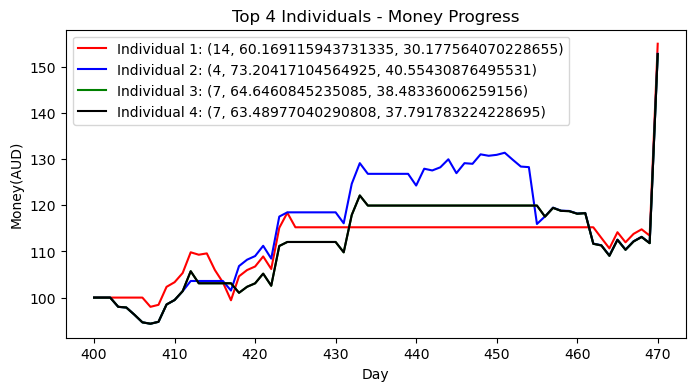

Generation 2: Top 10 individuals and their fitness:
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01
Individual (14, 60.169115943731335, 30.177564070228655) - Fitness: 155.01


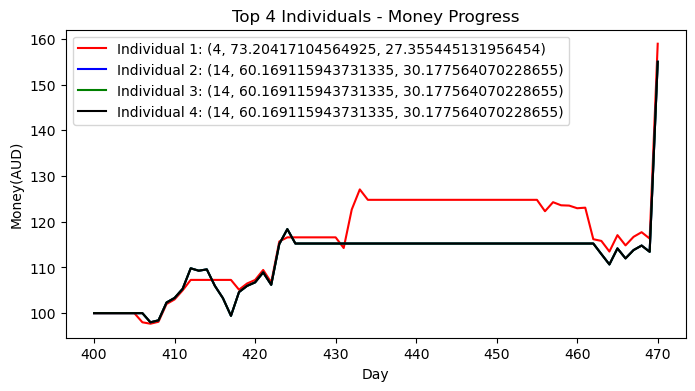

Generation 3: Top 10 individuals and their fitness:
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96
Individual (4, 73.20417104564925, 27.355445131956454) - Fitness: 158.96


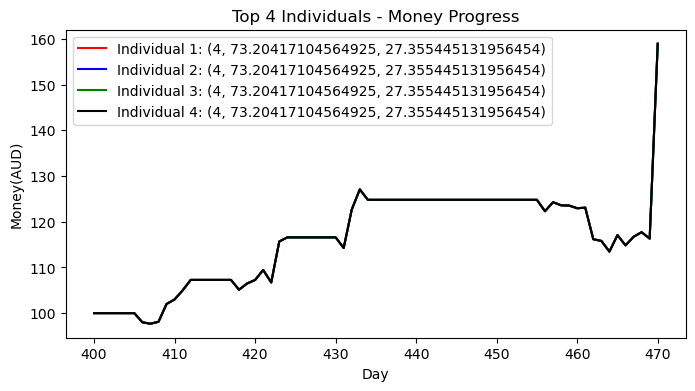

------------------------test---------------------------


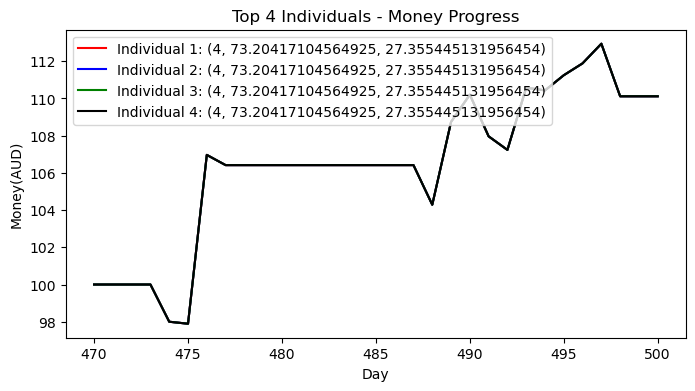




The day from  500  to  599 days.
------------------------train---------------------------
Generation 1: Top 10 individuals and their fitness:
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (22, 60.28374311696896, 49.44712883834018) - Fitness: 162.93
Individual (16, 63.84817506382239, 48.29662624049013) - Fitness: 162.76
Individual (17, 62.958796991661096, 47.301965203449775) - Fitness: 162.76
Individual (8, 62.731298605345444, 45.13040956773236) - Fitness: 162.45
Individual (6, 67.29210648309709, 38.96233317001345) - Fitness: 162.45
Individual (8, 65.97940428869859, 46.17531262982561) - Fitness: 162.45
Individual (6, 67.45961603226944, 41.54494667020606) - Fitness: 162.45
Individual (7, 68.21885915026759, 43.482794137669444) - Fitness: 162.45
Individual (10, 62.823149431424376, 49.471911946667646) - Fitness: 162.45


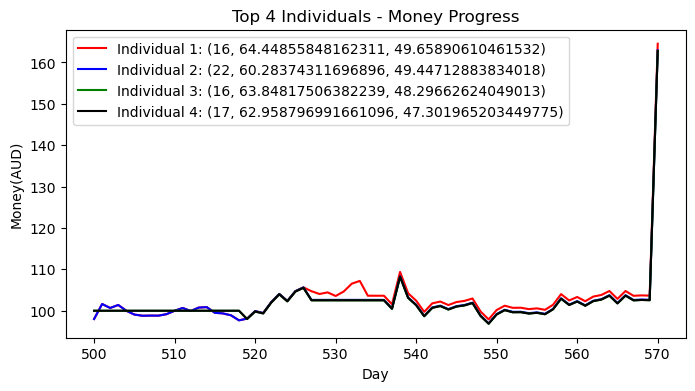

Generation 2: Top 10 individuals and their fitness:
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.008501044863294) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.471911946667646) - Fitness: 164.52


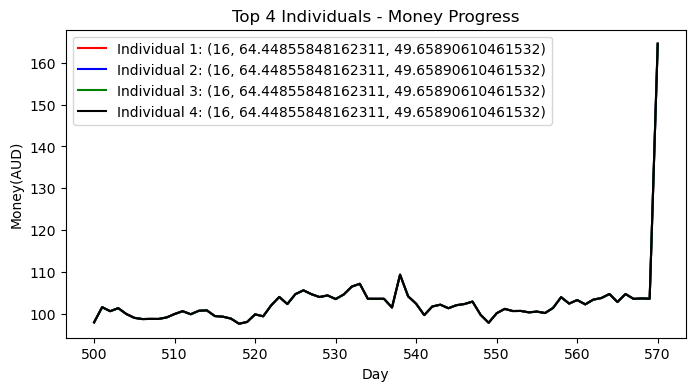

Generation 3: Top 10 individuals and their fitness:
Individual (16, 64.44855848162311, 50) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 50) - Fitness: 164.52
Individual (16, 64.44855848162311, 50) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.008501044863294) - Fitness: 164.52
Individual (16, 64.44855848162311, 50) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52
Individual (16, 64.44855848162311, 49.65890610461532) - Fitness: 164.52


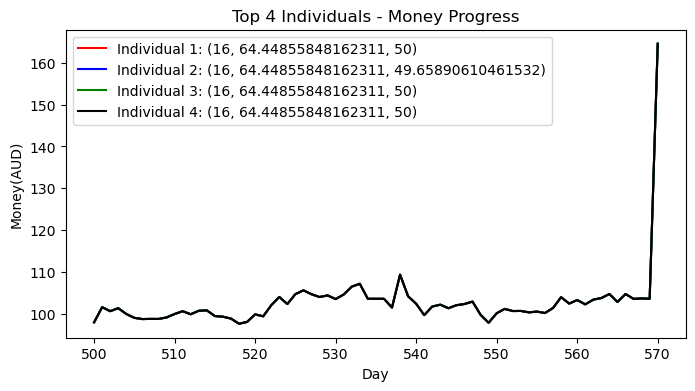

------------------------test---------------------------


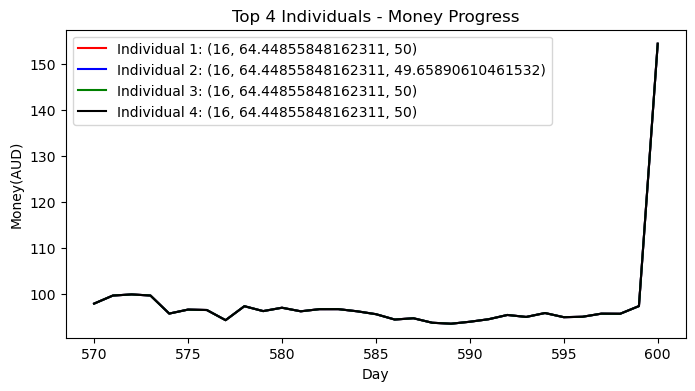




The day from  600  to  699 days.
------------------------train---------------------------
Generation 1: Top 10 individuals and their fitness:
Individual (29, 71.8666822309885, 48.361198140998944) - Fitness: 155.18
Individual (30, 76.45937836795734, 49.62341375166308) - Fitness: 150.97
Individual (30, 88.40474473701602, 49.79141828006227) - Fitness: 150.97
Individual (29, 82.64056727846125, 48.759540834648504) - Fitness: 150.97
Individual (27, 89.87077704702429, 49.699198283935594) - Fitness: 150.97
Individual (30, 89.3164727311763, 48.95730882737234) - Fitness: 150.97
Individual (26, 88.74552574280885, 49.60011093262109) - Fitness: 150.97
Individual (27, 79.86505002285958, 49.95707363572663) - Fitness: 150.97
Individual (30, 78.7814541139067, 48.17349566174107) - Fitness: 150.97
Individual (29, 86.81479974623672, 49.216596700628486) - Fitness: 150.97


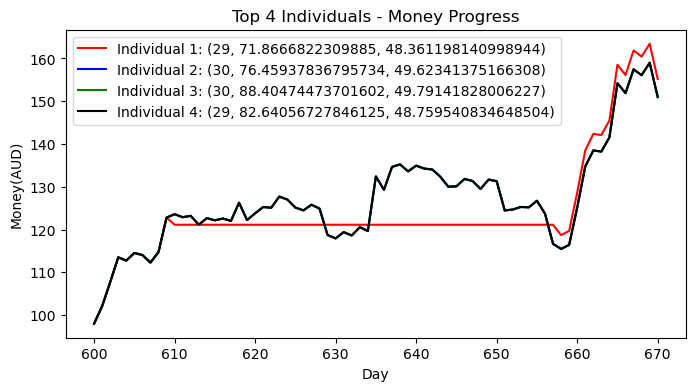

Generation 2: Top 10 individuals and their fitness:
Individual (29, 71.8666822309885, 50) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.60011093262109) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.60011093262109) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.216596700628486) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.95707363572663) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.60011093262109) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.699198283935594) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.62341375166308) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.468755778861095) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.60011093262109) - Fitness: 155.18


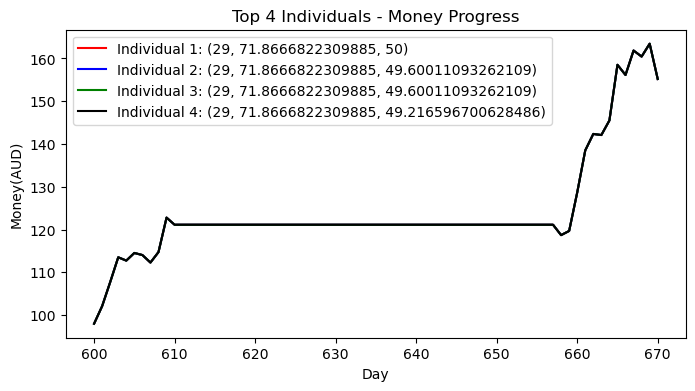

Generation 3: Top 10 individuals and their fitness:
Individual (29, 68.80925200521565, 50) - Fitness: 157.22
Individual (29, 71.8666822309885, 48.361198140998944) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.79141828006227) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.79141828006227) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.62341375166308) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.79141828006227) - Fitness: 155.18
Individual (29, 71.8666822309885, 50) - Fitness: 155.18
Individual (29, 71.8666822309885, 49.79141828006227) - Fitness: 155.18
Individual (29, 71.8666822309885, 48.95730882737234) - Fitness: 155.18
Individual (29, 71.8666822309885, 48.95730882737234) - Fitness: 155.18


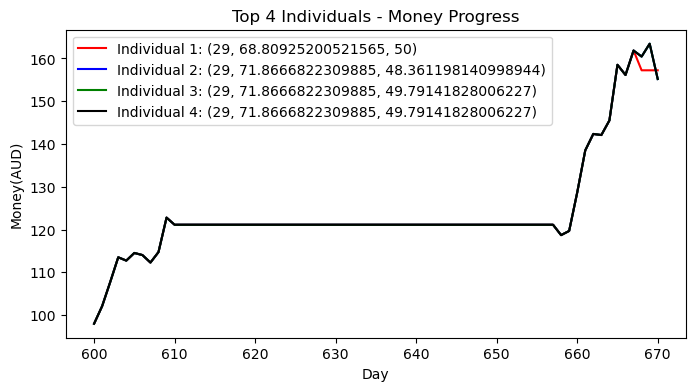

------------------------test---------------------------


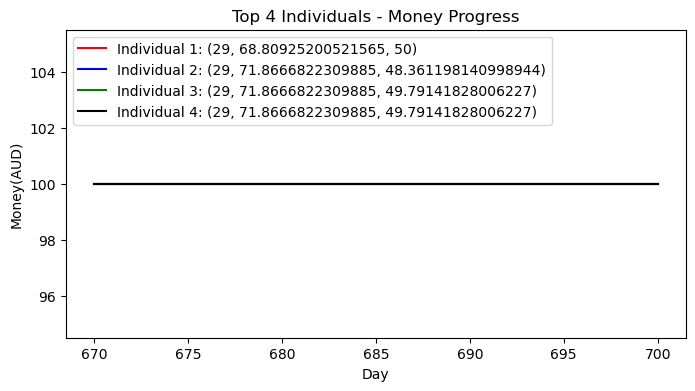

In [10]:
for i in range(4, 7):
    train_start_time = i * 100
    train_end_time = i * 100 + 69
    test_start_time = train_end_time + 1
    test_end_time = i * 100 + 99
    print('The day from ', train_start_time, ' to ', test_end_time, 'days.')
    #train
    print('------------------------train---------------------------')
    top_individuals = genetic_algorithm(df_data, train_start_time, train_end_time)
    # test
    print('------------------------test---------------------------')
    draw_top_individuals(top_individuals, test_start_time, test_end_time)
    print()
    print()
    print()